In [86]:
import os
import math
import pandas_datareader as web # stock values
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, ConvLSTM1D, Conv2D, Conv1D, LSTM
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, MaxPooling1D

import matplotlib.pyplot as plt
import seaborn as sns
import warnings


%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
company = 'FB'

start = dt.datetime(2012,1,1)
end = dt.datetime(2021,1,1)
df = web.DataReader(company, 'yahoo', start, end)

df


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999
...,...,...,...,...,...,...
2020-12-24,270.399994,266.200012,268.880005,267.399994,6702000,267.399994
2020-12-28,277.299988,265.660004,268.739990,277.000000,23299700,277.000000
2020-12-29,280.510010,276.279999,276.950012,276.779999,16383000,276.779999


In [6]:
dataset = df[['High', 'Low', 'Open' ,'Close']].astype(float)
dataset.head()

,High,Low,Open,Close
Date,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

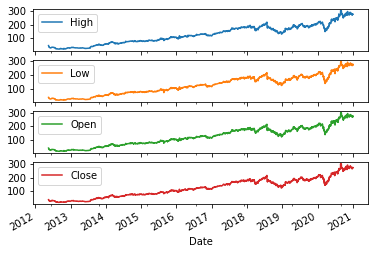

In [7]:
dataset.plot(subplots=True)

In [8]:
# multi variables
cols = list(dataset)
cols

['High', 'Low', 'Open', 'Close']

In [31]:
# Preprocessing + reshape dataset  (time, var, values, channel=1)
scaler =  MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset.values.reshape(-1, len(cols)))
scaled_data.shape

(2170, 4)

In [11]:
display(pd.DataFrame(scaled_data, columns = cols).head())

,High,Low,Open,Close
0,0.093331,0.074229,0.084976,0.071633
1,0.064211,0.056080,0.065407,0.056957
2,0.053492,0.048603,0.051510,0.046369
3,0.049686,0.050127,0.047114,0.049864
4,0.052165,0.051615,0.052716,0.053463


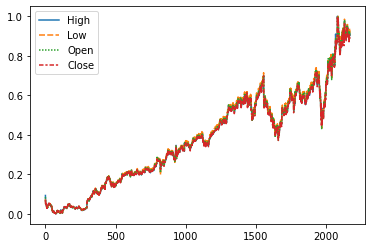

In [12]:
sns.lineplot(data=pd.DataFrame(scaled_data))
plt.legend(labels=cols)

In [32]:
# Split train/test data
train_dataset, test_dataset = np.vsplit(scaled_data, [int(len(dataset)*0.8)])
train_dataset.shape, test_dataset.shape

((1736, 4), (434, 4))

In [93]:
train_datasetEX = np.expand_dims(train_dataset, axis = 2)
train_datasetEX.shape

(1736, 4, 1)

In [99]:
x_train = []
y_train = []

# use 7days for prediction
n_future = 1
n_past = 7

for i in range(n_past, len(train_dataset)-n_future+1):
    x_train.append(train_datasetEX[i-n_past:i, 0:train_dataset.shape[1]])
    y_train.append(train_dataset[i:i+n_future, 0:train_dataset.shape[1]])

In [100]:
x_train, y_train = np.array(x_train), np.array(y_train)


In [101]:

x_train.shape, y_train.shape 

((1729, 7, 4, 1), (1729, 1, 4))

In [108]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, padding = 'same', activation="relu"), input_shape=(None, x_train.shape[2], x_train.shape[3])))
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, padding = 'same', activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Conv1D(filters=16, kernel_size=3, padding = 'same', activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))

# LSTM layer
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(x_train.shape[2], return_sequences=False))


model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_52 (TimeDis (None, None, 4, 64)       256       
_________________________________________________________________
time_distributed_53 (TimeDis (None, None, 4, 32)       6176      
_________________________________________________________________
time_distributed_54 (TimeDis (None, None, 4, 32)       0         
_________________________________________________________________
time_distributed_55 (TimeDis (None, None, 4, 16)       1552      
_________________________________________________________________
time_distributed_56 (TimeDis (None, None, 4, 16)       0         
_________________________________________________________________
time_distributed_57 (TimeDis (None, None, 4, 16)       0         
_________________________________________________________________
time_distributed_58 (TimeDis (None, None, 64)        

In [109]:
history = model.fit(x_train, y_train, epochs =50, batch_size=32,
                    validation_split=0.20, verbose=1, shuffle = False)

Epoch 1/50
44/44 [==============================] - 8s 49ms/step - loss: 0.0079 - val_loss: 0.0052
Epoch 2/50
44/44 [==============================] - 1s 21ms/step - loss: 0.0492 - val_loss: 0.0393
Epoch 3/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0193 - val_loss: 0.0165
Epoch 4/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0084 - val_loss: 0.0061
Epoch 5/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 6/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 7/50
44/44 [==============================] - 1s 18ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 8/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 9/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 10/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 11/

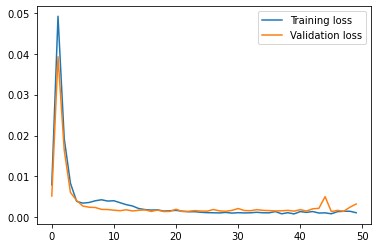

In [111]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [112]:
# forecast
test_datasetEX = np.expand_dims(test_dataset, axis = 2)
test_datasetEX.shape

x_test = []
y_test = []

for i in range(n_past, len(test_dataset)-n_future+1):
    x_test.append(test_datasetEX[i-n_past:i, 0:test_dataset.shape[1]])
    y_test.append(test_dataset[i:i+n_future, 0:test_dataset.shape[1]])
    
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((427, 7, 4, 1), (427, 1, 4))

In [113]:
forecast = model.predict(x_test)

In [114]:
forecast.shape

(427, 4)

In [115]:
# denormalize the predicted values

predicted = scaler.inverse_transform(forecast)
predicted.shape

(427, 4)

In [116]:
train_unscaled = scaler.inverse_transform(y_train.reshape(-1, y_train.shape[2]))
test_unscaled = scaler.inverse_transform(y_test.reshape(-1, y_test.shape[2]))

In [117]:
train_unscaled.shape,test_unscaled.shape

((1729, 4), (427, 4))

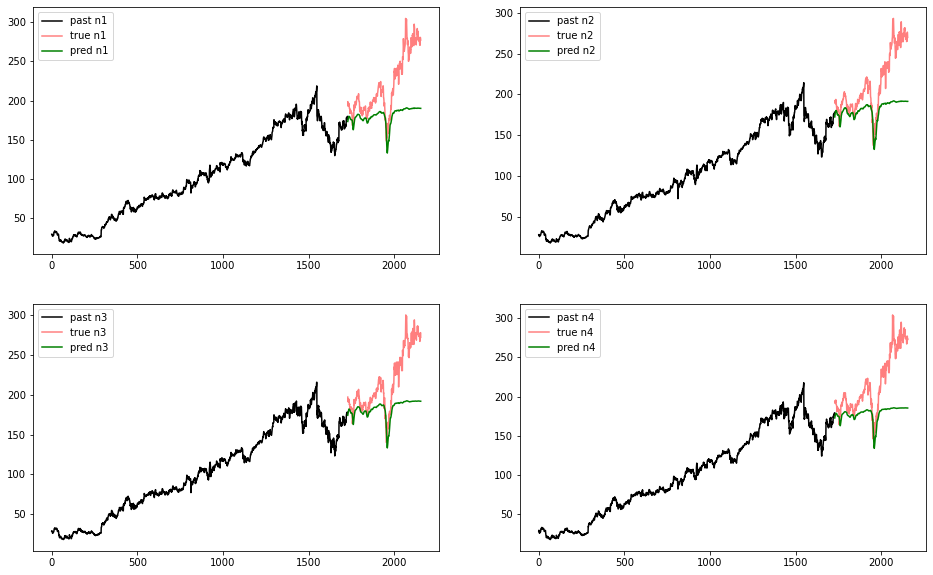

In [118]:
# Check Predictions

a_axis = np.arange(0, len(y_train))
b_axis = np.arange(len(y_train), len(y_train)+len(y_test))

plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plt.plot(a_axis, train_unscaled[:,0], color = 'black', label ='past n1')
plt.plot(b_axis, test_unscaled[:,0], color = 'red', alpha=0.5, label ='true n1')
plt.plot(b_axis, predicted[:,0], color = 'green', label ='pred n1')
plt.legend()

plt.subplot(2,2,2)
plt.plot(a_axis, train_unscaled[:,1], color = 'black', label ='past n2')
plt.plot(b_axis, test_unscaled[:,1], color = 'red', alpha=0.5, label ='true n2')
plt.plot(b_axis, predicted[:,1], color = 'green', label ='pred n2')
plt.legend()

plt.subplot(2,2,3)
plt.plot(a_axis, train_unscaled[:,2], color = 'black', label ='past n3')
plt.plot(b_axis, test_unscaled[:,2], color = 'red', alpha=0.5, label ='true n3')
plt.plot(b_axis, predicted[:,2], color = 'green', label ='pred n3')
plt.legend()

plt.subplot(2,2,4)
plt.plot(a_axis, train_unscaled[:,3], color = 'black', label ='past n4')
plt.plot(b_axis, test_unscaled[:,3], color = 'red', alpha=0.5, label ='true n4')
plt.plot(b_axis, predicted[:,3], color = 'green', label ='pred n4')

plt.legend()

plt.show()


In [131]:
import math

testScore = math.sqrt(mean_squared_error(test_unscaled[:200,0], predicted[:200,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 18.65 RMSE
